# Демо-экзамен по курсу "Прикладной анализ данных". Вариант 1

Выполнил: *Оберемок Дмитрий Олегович*

Название ВУЗа, в котором обучаетесь: НИЯУ МИФИ

Вставьте ниже скриншот с результатом вашего решения в Leaderboard на Kaggle: https://www.kaggle.com/competitions/where-are-the-seagulls

![Результат](results/result_8_2.png)

## 1. Описание задачи

В 4 километрах от тихоокеанского берега Камчатки в бухте Вестник лежит остров Уташуд — часть Южно-Камчатского федерального заказника. На нем живут каланы, антуры, тюлени ларги, около 50 тысяч птиц десяти разных видов, включая колонию топорика численностью 10 тысяч пар. В данной задаче нас интересуют двое обитателей острова – ларга и тихоокеанская чайка, за которыми осуществляется наблюдение через фотоловушки в летний сезон.

На Уташуде находится репродуктивное лежбище тюленей-ларга и одно из крупнейших на Камчатке поселений тихоокеанской чайки (4 тысяч пар). За 1 сезон наблюдения за этими животными может накопиться более 1800 фотографий различного качества. Через эти фотографии инспекторы оценивают благополучие и численность животных.

Разработайте алгоритм, который бы позволил производить учет чаек и выделять их по фотографии.

Ссылка на соревнование и на данные: https://www.kaggle.com/competitions/where-are-the-seagulls

## 2. Загрузка данных и подключение библиотек

In [1]:
# Установим библиотеку для работы с датасетами на kaggle

!pip install opendatasets --quiet

Небольшая инструкция, как напрямую скачать данные с kaggle в Colab-ноутбук: https://www.geeksforgeeks.org/python/how-to-import-kaggle-datasets-directly-into-google-colab/

In [3]:
# Загрузим датасеты на локальный компьютер

import opendatasets as od

url = 'https://www.kaggle.com/competitions/where-are-the-seagulls'
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading where-are-the-seagulls.zip to .\where-are-the-seagulls


100%|██████████| 36.7M/36.7M [00:00<00:00, 699MB/s]


Extracting archive .\where-are-the-seagulls/where-are-the-seagulls.zip to .\where-are-the-seagulls


In [1]:
# Импортируем библиотеки для работы с файлами

import os
import shutil

from pathlib import Path

In [5]:
# Переместим папку data из where-are-the-seagulls в корневую папку

source_directory = 'where-are-the-seagulls/data'
destination_directory = 'data'

os.makedirs(destination_directory, exist_ok=True)

for item in os.listdir(source_directory):
    source = os.path.join(source_directory, item)
    destination = os.path.join(destination_directory, item)

    if os.path.isdir(source):
        shutil.copytree(source, destination, dirs_exist_ok=True)

    else:
        shutil.copy2(source, destination)

shutil.rmtree('where-are-the-seagulls')

In [7]:
# Будем использовать библиотеку ultralytics для обучения модели

!pip install ultralytics

In [66]:
# Будем использовать библиотеку OpenCV для работы с изображениями

!pip install opencv-python

In [2]:
# Импортируем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import cv2

import torch
from ultralytics import YOLO
import yaml

## 3. Провести предварительное исследование данных

- в каком формате представлены данные?
- какие есть особенности датасета?
- если необходимо, произвести очистку и предварительную обработку данных

- ### В каком формате представлены данные?
  <br>

  - #### Структура:

    - Картинки: **train/images/** и **test/images/** — изображения в формате .jpg

    - Разметка: **train/labels/** — YOLO-формат .txt

    - **test/labels/** отсутствует (наша задача - как раз находить чаек)
  
    <br>

  - #### YOLO-разметка:

    - Файл .txt для каждого изображения с аннотациями:

      - **class_id**; **x_center**; **y_center**; **width**; **height**
  <br>

  - Все координаты нормализованы — значения от 0 до 1 относительно ширины и высоты изображения

- ### Какие есть особенности датасета?

  - Одна категория: 0 — чайка (seagull)

  - Наблюдаются разные размеры объектов

  - Могут быть пустые изображения (без чаек) — в том числе и в тестах

  - Сильный дисбаланс по количеству объектов на изображениях: где-то 0, где-то 5–10 чаек

  - Разные условия съёмки — фон, освещение, плотность объектов


  - ### Если необходимо, произвести очистку и предварительную обработку данных

In [9]:
# Удостоверимся, что формат картинок - .jpg, а формат меток - .txt

images_directory = 'data/train/images'
labels_directory = 'data/train/labels'

wrong_image_files = [file for file in os.listdir(images_directory) if not file.lower().endswith('.jpg')]

if wrong_image_files:
    print('Найдены изображения с неверным форматом (не .jpg)')

else:
    print('Все изображения в формате .jpg')

wrong_label_files = [file for file in os.listdir(labels_directory) if not file.lower().endswith('.txt')]

if wrong_label_files:
    print('Найдены файлы меток с неверным форматом (не .txt)')

else:
    print('Все файлы меток в формате .txt')

Все изображения в формате .jpg
Все файлы меток в формате .txt


In [10]:
# Убедимся, что для каждого изображения в train/images есть аннотация в train/labels

image_files = [file for file in os.listdir(images_directory)]
missing_labels = []

for image_file in image_files:
    base_name = os.path.splitext(image_file)[0]
    label_file = f'{base_name}.txt'

    if not os.path.exists(os.path.join(labels_directory, label_file)):
        missing_labels.append(base_name)

if missing_labels:
    print('Не все изображения имеют соответствующие аннотации')

else:
    print('Все изображения имеют соответствующие аннотации')

Все изображения имеют соответствующие аннотации


In [12]:
# Посмотрим, какие относительные размеры имеют чайки и сколько всего на картинках чаек

all_widths = []
all_heights = []

total_objects = 0

for this_label in os.listdir(labels_directory):
    path = os.path.join(labels_directory, this_label)

    with open(path, 'r') as file:
        lines = file.readlines()
        total_objects += len(lines)

        for this_line in lines:
            parts = this_line.split()

            # Проверим, соответствует ли формат YOLO-разметке везде
            if len(parts) != 5:
                print(f'Есть ошибка в данных в файле {path}')
                continue

            this_class_id, this_x_center, this_y_center, this_width, this_height = map(float, parts)

            all_widths.append(this_width)
            all_heights.append(this_height)

print(f'Общее количество чаек: {total_objects}')

Общее количество чаек: 5386


In [13]:
# Посмотрим, какие размеры у наших картинок (в том числе у тестовых)

sizes = set()

for image_file in os.listdir(images_directory):
    path = os.path.join(images_directory, image_file)

    try:
        with Image.open(path) as this_image:
            this_width, this_height = this_image.size
            sizes.add((this_width, this_height))

    except Exception as error:
        print(f'Ошибка при обработке {image_file}: {error}')

test_images_directory = 'data/test/images'

for image_file in os.listdir(test_images_directory):
    path = os.path.join(test_images_directory, image_file)

    try:
        with Image.open(path) as this_image:
            this_width, this_height = this_image.size
            sizes.add((this_width, this_height))

    except Exception as error:
        print(f'Ошибка при обработке {image_file}: {error}')

print('Размеры картинок')

for size in sizes:
    print(f'{size[0]}x{size[1]}')

Размеры картинок
640x640


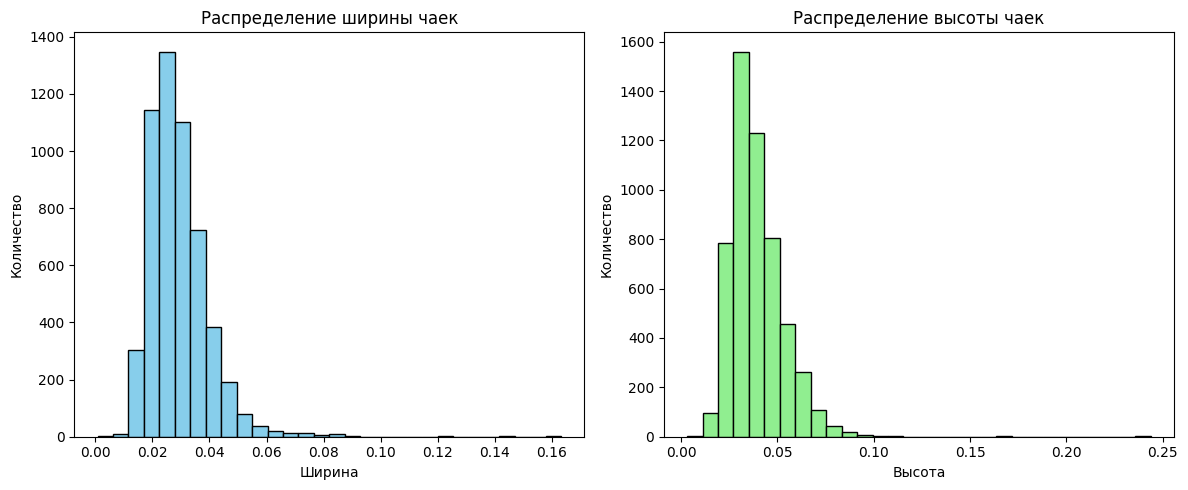

In [14]:
# Построим гистограммы

%matplotlib inline

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(all_widths, bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение ширины чаек')
plt.xlabel('Ширина')
plt.ylabel('Количество')

plt.subplot(1, 2, 2)
plt.hist(all_heights, bins=30, color='lightgreen', edgecolor='black')
plt.title('Распределение высоты чаек')
plt.xlabel('Высота')
plt.ylabel('Количество')

plt.tight_layout()
plt.show()

In [15]:
# Посчитаем, какой размер у чаек в среднем

average_width = sum(all_widths) / len(all_widths) * 640
average_height = sum(all_heights) / len(all_heights) * 640

print(f'Средний размер чаек: {round(average_width)}x{round(average_height)} пикселей')

Средний размер чаек: 19x25 пикселей


In [16]:
# Посчитаем, какой размер у чаек по медиане

import statistics

median_width = statistics.median(all_widths) * 640
median_height = statistics.median(all_heights) * 640

print(f'Медианный размер чаек: {round(median_width)}x{round(median_height)} пикселей')

Медианный размер чаек: 18x24 пикселей


Видим, что распределения размеров объектов примерно равномерные, присутствуют небольшие выбросы. Однако такие выбросы не являются шумом — наоборот, они отражают естественное разнообразие: чайки могут занимать как небольшую, так и значительную часть изображения

Нейронная сеть должна уметь распознавать объекты разных размеров, поэтому наличие как маленьких, так и крупных чаек — важно для обучения

Обнаруживать большие объекты, как правило, проще, так как они содержат больше пикселей и признаков. Но при этом важно, чтобы в обучающей выборке присутствовали разнообразные примеры крупных чаек — с разными фонами, ракурсами и положениями. Если таких примеров мало или они однотипные, модель может хуже обобщать на новые случаи

В целом, текущее распределение выглядит разумным, и количество крупных объектов, даже если оно меньше, вполне может быть достаточным, при условии их разнообразия

## 4. Подготовить данные для обучения

- Создать тренировочную и тестовую подвыборки для обучения и тестирования работы моделей
- Создать класс на фреймворке `PyTorch` для создания датасета
- Создать `loader` для передачи данных в модель нейронной сети

Возможно, вам это поможет: https://docs.ultralytics.com/datasets/detect/#ultralytics-yolo-format

In [17]:
# Создадим валидационную выборку

import random

val_images_directory = 'data/val/images'
val_labels_directory = 'data/val/labels'

if (os.path.exists(val_images_directory) and os.path.isdir(val_images_directory) or
        os.path.exists(val_labels_directory) and os.path.isdir(val_labels_directory)):
    print('Валидационные файлы уже есть')

else:
    os.makedirs(val_images_directory, exist_ok=True)
    os.makedirs(val_labels_directory, exist_ok=True)

    val_size = int(0.2 * len(image_files))
    val_files = random.sample(image_files, val_size)

    for file in val_files:
        shutil.move(str(os.path.join(images_directory, file)), str(os.path.join(val_images_directory, file)))
        label_file = file.replace('.jpg', '.txt')
        shutil.move(str(os.path.join(labels_directory, label_file)),
                    str(os.path.join(val_labels_directory, label_file)))

In [18]:
from torch.utils.data import Dataset


class SeagullDataset(Dataset):
    def __init__(self, image_directory, label_directory, transform=None, model=None):
        self.image_directory = image_directory
        self.label_directory = label_directory
        self.transform = transform
        self.model = model

        self.images = [image for image in os.listdir(image_directory)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # Загружаем изображение
        image_name = self.images[index]
        image_path = os.path.join(self.image_directory, image_name)
        image = Image.open(image_path).convert('RGB')

        # Загружаем метки
        label_path = os.path.join(self.label_directory, image_name.replace('.jpg', '.txt'))
        boxes = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                for line in file.readlines():
                    class_id, _x_center, _y_center, _width, _height = map(float, line.split())
                    boxes.append([1., _x_center, _y_center, _width, _height])
                    # первый параметр - уверенность модели, что перед нами чайка

        boxes = torch.tensor(boxes) if boxes else torch.zeros((0, 5))

        if self.transform:
            image = self.transform(image)

        return image, boxes

In [19]:
class SeagullTestDataset(Dataset):
    def __init__(self, image_directory, transform=None):
        self.image_directory = image_directory
        self.transform = transform

        self.images = [image for image in os.listdir(image_directory)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_name = self.images[index]
        image_path = os.path.join(self.image_directory, image_name)
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, image_path

In [20]:
# Создадим функцию collate_fn, чтобы она создавала батчи из тензоров

def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)

    return images, labels

In [21]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

to_transform = transforms.ToTensor()

train_dataset = SeagullDataset('data/train/images', 'data/train/labels', transform=to_transform)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, collate_fn=collate_fn)

val_dataset = SeagullDataset("data/val/images", "data/val/labels", transform=to_transform)
val_loader = DataLoader(val_dataset, batch_size=10, collate_fn=collate_fn)

test_dataset = SeagullTestDataset('data/test/images', transform=to_transform)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), collate_fn=collate_fn)

## 5. Реализация модели

- создать класс для модели
- создать функцию для обучения модели
- создать функцию для валидации модели

In [22]:
# Попробуем сначала придумать свою модель

import torch.nn as nn
import torch.nn.functional as functional


class SeagullDetectionModel(nn.Module):
    def __init__(self):
        super(SeagullDetectionModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )

        self.max_objects = 20
        self.regressor = nn.Linear(128, self.max_objects * 5)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.regressor(x)
        x = functional.sigmoid(x)
        x = x.view(-1, self.max_objects, 5)
        return x

In [23]:
# Адаптируем ResNet под задачу обнаружения чаек

from torchvision.models import resnet18, ResNet18_Weights


class ResNetDetector(nn.Module):
    def __init__(self):
        super(ResNetDetector, self).__init__()
        weights = ResNet18_Weights.DEFAULT
        resnet = resnet18(weights=weights)

        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        self.max_objects = 20

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, self.max_objects * 5)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        x = x.view(-1, self.max_objects, 5)
        x = torch.sigmoid(x)
        return x

In [24]:
# Функция для обучения

def train_one_epoch(model, train_dataloader, optimizer, loss_fn, epoch, device, verbose=False):
    model.train()
    total_loss = 0.

    for batch_index, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)

        if loss_fn == 'faster_r-cnn':
            labels = [{k: v.to(device) for k, v in label.items()} for label in labels]

            loss_dict = model(images, labels)
            loss = sum(l for l in loss_dict.values())

        else:
            labels = [label.to(device) for label in labels]

            outputs = model(images)
            loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if verbose:
        print(f'Обучение: '
              f'Эпоха: {epoch}; '
              f'Ошибка: {total_loss:.4f}')

    return total_loss / len(train_dataloader)

In [25]:
# Функция для валидации

@torch.no_grad()
def valid_one_epoch(model, valid_dataloader, loss_fn, epoch, device, verbose=False):
    model.eval()
    total_loss = 0.

    for batch_index, (images, labels) in enumerate(valid_dataloader):
        images = images.to(device)

        if loss_fn == 'faster_r-cnn':
            labels = [{k: v.to(device) for k, v in label.items()} for label in labels]

            loss_dict = model(images, labels)
            loss = sum(l for l in loss_dict.values())

        else:
            labels = [label.to(device) for label in labels]

            outputs = model(images)
            loss = loss_fn(outputs, labels)

        total_loss += loss.item()

    if verbose:
        print(f'Валидация: '
              f'Эпоха: {epoch}; '
              f'Ошибка: {total_loss:.4f}\n')

    return total_loss / len(valid_dataloader)

## 6. Обучение модели
*   Определить необходимые параметры для обучения модели (learning rate, optimizer, loss function, etc)
*   Реализовать процесс обучения модели
*   Оценить эффективность работы модели



In [26]:
# Создадим функцию потерь для обнаружения чаек

class DetectionLoss(nn.Module):
    def __init__(self, lambda_coord=5, lambda_conf=0.5):
        super().__init__()
        self.coord_loss = nn.SmoothL1Loss()
        self.conf_loss = nn.BCEWithLogitsLoss()

        self.lambda_coord = lambda_coord
        self.lambda_conf = lambda_conf

    def forward(self, preds, targets):
        total_loss = 0.
        valid_batches = 0

        for pred, target in zip(preds, targets):
            if pred.ndim == 1:
                pred = pred.unsqueeze(0)

            if target.ndim == 1:
                target = target.unsqueeze(0)

            min_length = min(pred.shape[0], target.shape[0])

            if min_length == 0:
                if pred.shape[0] > 0:
                    conf_pred = pred[:, 0]
                    target_conf = torch.zeros_like(conf_pred)
                    conf_loss = self.conf_loss(conf_pred, target_conf)
                    total_loss += self.lambda_conf * conf_loss
                    valid_batches += 1

                continue

            pred_boxes = pred[:min_length]
            target_boxes = target[:min_length]

            if torch.isnan(pred_boxes).any() or torch.isnan(target_boxes).any():
                continue

            if torch.isinf(pred_boxes).any() or torch.isinf(target_boxes).any():
                continue

            conf_pred = pred_boxes[:, 0]
            box_pred = pred_boxes[:, 1:]

            conf_target = target_boxes[:, 0]
            box_target = target_boxes[:, 1:]

            conf_loss = self.conf_loss(conf_pred, conf_target)
            coord_loss = self.coord_loss(box_pred, box_target)

            loss = self.lambda_conf * conf_loss + self.lambda_coord * coord_loss
            total_loss += loss
            valid_batches += 1

        if valid_batches == 0:
            return torch.tensor(0., device=preds[0].device, requires_grad=True)

        return total_loss / valid_batches

#### Минусы этой функции потерь:
    Нет IoU — не учитывает перекрытие боксов, только координаты
    Сопоставление по порядку — просто обрезает pred и target до min длины, не ищет реальные соответствия
    Нет обработки фоновых боксов — всё считается как положительный пример
    Плохо работает при разном числе объектов — особенно когда target пуст

In [27]:
# Определим функцию для обучения модели

import torch.optim as optim


def train_model(model_class, loss_function, epochs=10, learning_rate=0.001, device=None, verbose=True):
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model_class().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    this_train_losses = []
    this_valid_losses = []

    for epoch in range(1, epochs + 1):
        this_train_loss = train_one_epoch(model, train_loader, optimizer, loss_function, epoch, device, verbose)
        this_valid_loss = valid_one_epoch(model, val_loader, loss_function, epoch, device, verbose)

        this_train_losses.append(this_train_loss)
        this_valid_losses.append(this_valid_loss)

    return model, this_train_losses, this_valid_losses

In [28]:
# Определим функцию для вывода графика ошибки на обучении и валидации по эпохам

def plot_losses(train_losses_for_plotting, valid_losses_for_plotting):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses_for_plotting) + 1),
             train_losses_for_plotting, label='Ошибка на обучении', marker='o')
    plt.plot(range(1, len(valid_losses_for_plotting) + 1),
             valid_losses_for_plotting, label='Ошибка на валидации', marker='x')
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибка')
    plt.title('Ошибка на обучении и валидации')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [150]:
# Определим гиперпараметры и обучим модель

model_0, train_losses_0, valid_losses_0 = train_model(SeagullDetectionModel, DetectionLoss(), epochs=10)

Обучение: Эпоха: 1; Ошибка: 12.5145
Валидация: Эпоха: 1; Ошибка: 2.1570

Обучение: Эпоха: 2; Ошибка: 8.6974
Валидация: Эпоха: 2; Ошибка: 2.1150

Обучение: Эпоха: 3; Ошибка: 8.6091
Валидация: Эпоха: 3; Ошибка: 2.1105

Обучение: Эпоха: 4; Ошибка: 8.5944
Валидация: Эпоха: 4; Ошибка: 2.1147

Обучение: Эпоха: 5; Ошибка: 8.6277
Валидация: Эпоха: 5; Ошибка: 2.1136

Обучение: Эпоха: 6; Ошибка: 8.6047
Валидация: Эпоха: 6; Ошибка: 2.1151

Обучение: Эпоха: 7; Ошибка: 8.6097
Валидация: Эпоха: 7; Ошибка: 2.1115

Обучение: Эпоха: 8; Ошибка: 8.5899
Валидация: Эпоха: 8; Ошибка: 2.1284

Обучение: Эпоха: 9; Ошибка: 8.6065
Валидация: Эпоха: 9; Ошибка: 2.1156

Обучение: Эпоха: 10; Ошибка: 8.5899
Валидация: Эпоха: 10; Ошибка: 2.1066



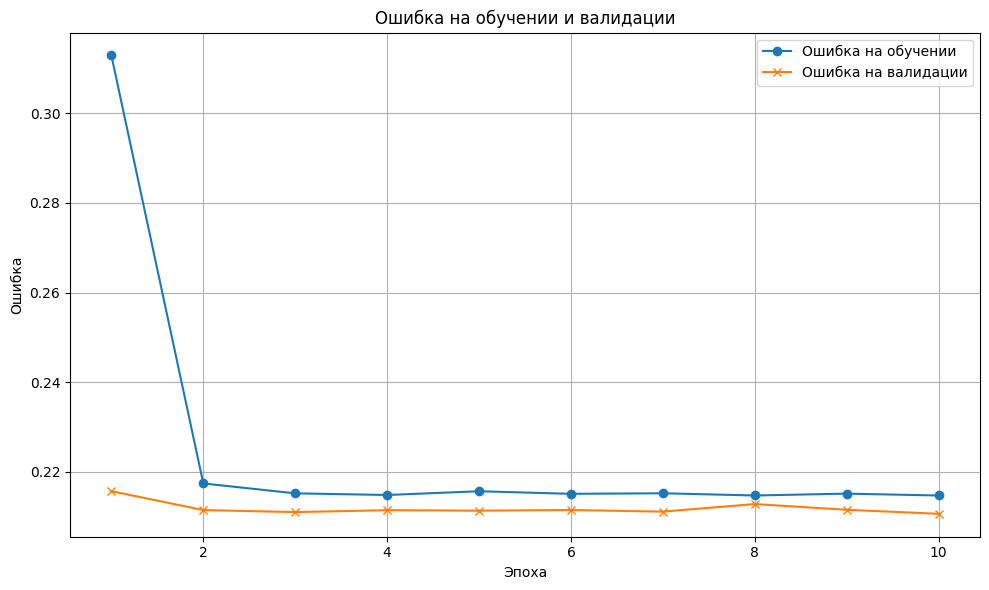

In [151]:
# Выведем графики ошибки 

plot_losses(train_losses_0, valid_losses_0)

In [108]:
# Попробуем ResNetDetector

model_1, train_losses_1, valid_losses_1 = train_model(ResNetDetector, DetectionLoss(), epochs=10)

Обучение: Эпоха: 1; Ошибка: 10.3053
Валидация: Эпоха: 1; Ошибка: 2.2840

Обучение: Эпоха: 2; Ошибка: 8.6187
Валидация: Эпоха: 2; Ошибка: 2.1257

Обучение: Эпоха: 3; Ошибка: 8.5839
Валидация: Эпоха: 3; Ошибка: 2.0958

Обучение: Эпоха: 4; Ошибка: 8.4806
Валидация: Эпоха: 4; Ошибка: 2.0866

Обучение: Эпоха: 5; Ошибка: 8.3686
Валидация: Эпоха: 5; Ошибка: 2.0626

Обучение: Эпоха: 6; Ошибка: 8.2291
Валидация: Эпоха: 6; Ошибка: 2.0556

Обучение: Эпоха: 7; Ошибка: 8.0478
Валидация: Эпоха: 7; Ошибка: 2.0362

Обучение: Эпоха: 8; Ошибка: 7.9471
Валидация: Эпоха: 8; Ошибка: 2.0780

Обучение: Эпоха: 9; Ошибка: 7.8833
Валидация: Эпоха: 9; Ошибка: 1.9872

Обучение: Эпоха: 10; Ошибка: 7.9476
Валидация: Эпоха: 10; Ошибка: 2.0550



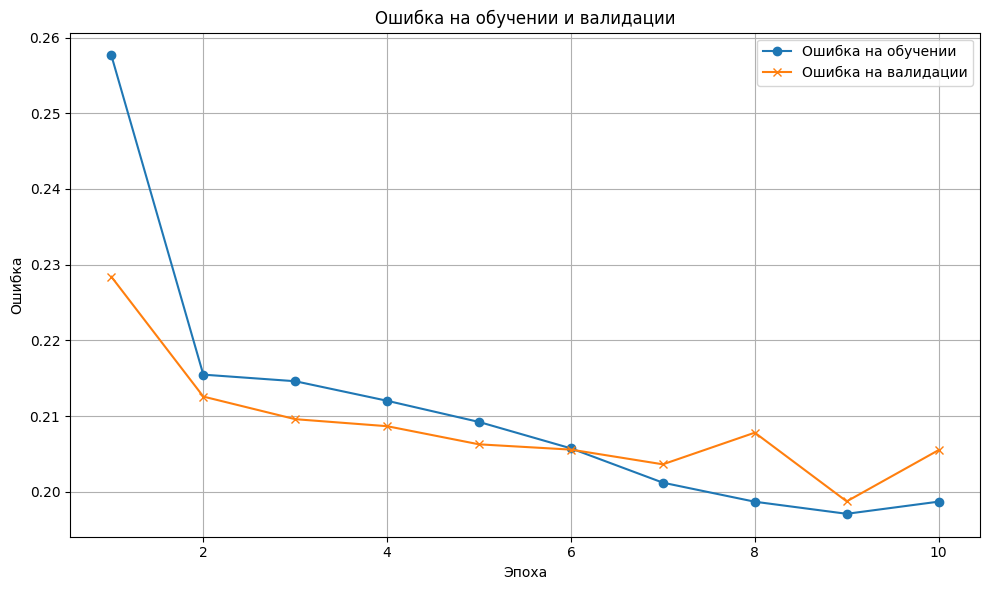

In [109]:
plot_losses(train_losses_1, valid_losses_1)

In [30]:
# Создадим data.yaml, необходимый для работы с библиотекой ultralytics

data = {
    'path': 'data',
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'names': {0: 'seagull'}
}

with open('data.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

In [19]:
import logging
import sys

# Чтобы не выводилась лишняя информация, которая занимает очень много места
logging.getLogger().setLevel(logging.CRITICAL)
os.environ['YOLO_VERBOSE'] = 'False'
sys.stdout = open(os.devnull, 'w')

In [421]:
# Обучим модель YOLO-8n

model_8 = YOLO("yolov8n.pt")
model_8.train(
    data="data.yaml",
    epochs=50,
    imgsz=640,
    batch=10,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

100%|██████████| 6.25M/6.25M [00:09<00:00, 709kB/s] 
train: Scanning C:\Users\Ober Belov\Desktop\Programming\Machine Learning\Projects\Seagull Detection\data\train\labels.cache... 400 images, 26 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]
C:\Users\Ober Belov\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\Ober Belov\Desktop\Programming\Machine Learning\Projects\Seagull Detection\data\val\labels.cache... 100 images, 6 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
C:\Users\Ober Belov\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
       1/50     

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002E8911C6B70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [461]:
# Обучим модель YOLO-8s

model_8_1 = YOLO("yolov8s.pt")
model_8_1.train(
    data="data.yaml",
    epochs=50,
    imgsz=640,
    batch=10,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

100%|██████████| 21.5M/21.5M [00:25<00:00, 878kB/s] 
train: Scanning C:\Users\Ober Belov\Desktop\Programming\Machine Learning\Projects\Seagull Detection\data\train\labels.cache... 400 images, 26 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]
C:\Users\Ober Belov\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\Ober Belov\Desktop\Programming\Machine Learning\Projects\Seagull Detection\data\val\labels.cache... 100 images, 6 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
C:\Users\Ober Belov\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
       1/50     

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002E88B9BF650>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [468]:
# Обучим модель YOLO-8m

model_8_2 = YOLO("yolov8m.pt")
model_8_2.train(
    data="data.yaml",
    epochs=50,
    imgsz=640,
    batch=10,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

100%|██████████| 49.7M/49.7M [00:18<00:00, 2.84MB/s]
train: Scanning C:\Users\Ober Belov\Desktop\Programming\Machine Learning\Projects\Seagull Detection\data\train\labels.cache... 400 images, 26 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]
C:\Users\Ober Belov\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\Ober Belov\Desktop\Programming\Machine Learning\Projects\Seagull Detection\data\val\labels.cache... 100 images, 6 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
C:\Users\Ober Belov\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
       1/50     

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002E88A6C8C20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [179]:
# Обучим модель YOLO-9t

model_9 = YOLO("yolov9t.pt")
model_9.train(
    data="data.yaml",
    epochs=50,
    imgsz=640,
    batch=10,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

100%|██████████| 4.74M/4.74M [00:02<00:00, 2.45MB/s]
C:\Users\Ober Belov\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Ober Belov\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Ober Belov\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000021C56220800>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [193]:
# Обучим модель YOLO-10n

model_10 = YOLO("yolov10n.pt")
model_10.train(
    data="data.yaml",
    epochs=50,
    imgsz=640,
    batch=10,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

100%|██████████| 5.59M/5.59M [00:02<00:00, 2.13MB/s]
C:\Users\Ober Belov\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Ober Belov\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Ober Belov\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000021C5AB200B0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [198]:
# Обучим модель YOLO-11n

model_11 = YOLO("yolo11n.pt")
model_11.train(
    data="data.yaml",
    epochs=50,
    imgsz=640,
    batch=10,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

100%|██████████| 5.35M/5.35M [00:05<00:00, 1.09MB/s]
C:\Users\Ober Belov\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Ober Belov\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Ober Belov\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000021C4D30AF90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [11]:
# Обучим модель YOLO-12n

model_12 = YOLO("yolo12n.pt")
model_12.train(
    data="data.yaml",
    epochs=50,
    imgsz=640,
    batch=10,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

100%|██████████| 5.34M/5.34M [00:02<00:00, 2.35MB/s]
train: Scanning C:\Users\Ober Belov\Desktop\Programming\Machine Learning\Projects\Seagull Detection\data\train\labels.cache... 400 images, 26 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]
C:\Users\Ober Belov\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\Ober Belov\Desktop\Programming\Machine Learning\Projects\Seagull Detection\data\val\labels.cache... 100 images, 6 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
C:\Users\Ober Belov\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
       1/50     

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000144B8600B30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

## 7. Экспериментальная часть

- протестировать не менее трёх разных моделей для решения задачи
- сравнить их эффективность (по метрикам и потерям)
- сделать выводы

In [32]:
# Реализуем функцию для сохранения предсказаний в файлы

def save_predictions(preds, image_path, predictions_directory, confidence_threshold):
    os.makedirs(predictions_directory, exist_ok=True)

    predict_base_name = os.path.splitext(os.path.basename(image_path))[0]
    predict_txt_path = os.path.join(predictions_directory, predict_base_name + '.txt')

    preds = preds.detach().cpu()

    with open(predict_txt_path, 'w') as file:
        for obj in preds:
            if obj.ndim == 1 and obj.numel() == 5:
                values = obj.tolist()

                if values[0] < confidence_threshold:  # отбрасываем объекты с низкой уверенностью предсказания
                    continue

                values[0] = 0  # класс всегда 0, меняем confidence на class_id

                line = ' '.join(str(round(v, 8)) for v in values)
                file.write(line + '\n')

In [33]:
# Реализуем функцию для предсказаний на тестах с сохранением в файлы

def predict_and_save(model, save_directory, confidence_threshold=0.95, device=None, verbose=True):
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    os.makedirs(save_directory, exist_ok=True)

    model.eval()

    with torch.no_grad():
        for test_images, test_image_paths in test_loader:
            test_images = test_images.to(device)
            test_outputs = model(test_images)

            if verbose:
                print(test_outputs)

            for output, image_path in zip(test_outputs, test_image_paths):
                save_predictions(output, image_path, save_directory, confidence_threshold)

In [34]:
# Создадим функцию для преобразования текстовых файлов в нужный нам csv-формат

def labels_to_csv(label_directory, output_path, image_directory='data/test/images'):
    submission = []
    test_image_files = sorted(os.listdir(image_directory))

    for index, test_image_file in enumerate(test_image_files):
        base_file_name = os.path.splitext(test_image_file)[0]
        txt_path = os.path.join(label_directory, base_file_name + '.txt')

        bboxes = []

        if os.path.exists(txt_path):
            with open(txt_path, 'r') as file:
                test_lines = file.readlines()

            if test_lines:
                for line in test_lines:
                    boxes = line.strip().split()
                    cls = boxes[0]
                    coords = boxes[1:]
                    bboxes.append(f"{cls} " + " ".join(coords))

            else:
                bboxes.append('-1')  # файл пустой

        else:
            bboxes.append('-1')  # файл не существует

        bbox_str = " ".join(bboxes)

        submission.append({
            'index': index,
            'filename': test_image_file,
            'bbox': bbox_str
        })

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df = pd.DataFrame(submission)
    df.to_csv(output_path, index=False)

In [48]:
# Пробуем обнаружить чаек на тестовой выборке с помощью придуманной модели

labels_0_directory = 'data/test/labels_0'
predict_and_save(model_0, save_directory=labels_0_directory, confidence_threshold=0.999)

tensor([[[0.9989, 0.3955, 0.7016, 0.0324, 0.0461],
         [0.9985, 0.4527, 0.6679, 0.0345, 0.0442],
         [0.9989, 0.4966, 0.6672, 0.0334, 0.0479],
         ...,
         [0.9821, 0.5734, 0.6684, 0.0400, 0.0480],
         [0.9749, 0.5585, 0.6670, 0.0416, 0.0502],
         [0.9086, 0.5937, 0.6539, 0.0402, 0.0533]],

        [[0.9989, 0.3949, 0.7025, 0.0318, 0.0454],
         [0.9986, 0.4526, 0.6688, 0.0339, 0.0435],
         [0.9989, 0.4966, 0.6679, 0.0328, 0.0472],
         ...,
         [0.9824, 0.5737, 0.6692, 0.0393, 0.0473],
         [0.9754, 0.5589, 0.6678, 0.0409, 0.0495],
         [0.9096, 0.5942, 0.6546, 0.0396, 0.0526]],

        [[0.9988, 0.3956, 0.7013, 0.0326, 0.0464],
         [0.9985, 0.4528, 0.6675, 0.0347, 0.0444],
         [0.9989, 0.4967, 0.6668, 0.0336, 0.0482],
         ...,
         [0.9819, 0.5733, 0.6681, 0.0402, 0.0483],
         [0.9747, 0.5583, 0.6666, 0.0419, 0.0505],
         [0.9081, 0.5934, 0.6535, 0.0405, 0.0537]],

        ...,

        [[0.9991, 0.

In [49]:
# Создадим submission_0.csv для модели model_0

submission_0_path = "submissions/submission_0.csv"
labels_to_csv(labels_0_directory, submission_0_path)

![Результат](results/result_0.png)

Модель, которую мы обучили, показывает очень слабые результаты в обнаружении чаек — она часто делает неверные предсказания или вовсе не находит объекты. Основная причина в том, что архитектура модели слишком простая для такой задачи: обнаружение объектов требует способности извлекать сложные пространственные признаки и точно локализовать объекты разного размера и формы

In [104]:
# Пробуем обнаружить чаек на тестовой выборке с помощью модели ResNet-18

labels_1_directory = 'data/test/labels_1'
predict_and_save(model_1, save_directory=labels_1_directory, confidence_threshold=0.9999)

tensor([[[ 0.9545,  0.5703,  0.8021,  0.0344,  0.0353],
         [-0.4329,  0.5785,  0.6058,  0.0430,  0.0612],
         [-1.7850,  0.4356,  0.6454,  0.1985, -0.1622],
         ...,
         [-4.4751,  0.3521,  1.0874,  0.2011,  0.1320],
         [-4.1407,  0.1512,  0.6075,  0.1310, -0.3686],
         [-3.9687,  0.4710,  1.1656, -0.2051,  0.3223]],

        [[ 0.9929,  0.5450,  0.7946,  0.0335,  0.0436],
         [-0.4171,  0.5793,  0.6117,  0.0325,  0.0545],
         [-1.7096,  0.4313,  0.6345,  0.1985, -0.1508],
         ...,
         [-4.3543,  0.3381,  1.0657,  0.1842,  0.1273],
         [-4.0156,  0.1600,  0.6110,  0.1349, -0.3424],
         [-3.8399,  0.4676,  1.1276, -0.1792,  0.3193]],

        [[ 1.0008,  0.5470,  0.7990,  0.0329,  0.0435],
         [-0.4194,  0.5834,  0.6148,  0.0347,  0.0536],
         [-1.7156,  0.4336,  0.6375,  0.1990, -0.1509],
         ...,
         [-4.3733,  0.3401,  1.0711,  0.1829,  0.1263],
         [-4.0359,  0.1599,  0.6142,  0.1342, -0.3452],
  

In [105]:
submission_1_path = "submissions/submission_1.csv"
labels_to_csv(labels_1_directory, submission_1_path)

![Результат](results/result_1.png)

ResNet-18 показывает слабые результаты

ResNet в сыром виде не приспособлен для обнаружения объектов. ResNet - это про классификацию изображений

Попробуем использовать готовые модели, заточенные именно под обнаружение объектов

In [9]:
# Получим данные из обученных моделей YOLO

yolo_path = 'runs/detect'
train_directories = [file for file in os.listdir(yolo_path) if file.startswith('train')]

results = []

for directory in train_directories:
    directory_path = os.path.join(yolo_path, directory)
    args_path = os.path.join(directory_path, 'args.yaml')
    results_path = os.path.join(directory_path, 'results.csv')

    if not os.path.isfile(args_path) or not os.path.isfile(results_path):
        print(f'Найдена битая директория: {directory}')
        continue

    with open(args_path, 'r') as file:
        args = yaml.safe_load(file)
        model_name = args.get('model', directory)

    result_data = pd.read_csv(results_path)
    last_epoch_data = result_data.iloc[-1]  # данные последней эпохи

    results.append({
        'Model': model_name,
        'Precision': last_epoch_data.get('metrics/precision(B)', float('nan')),
        'Recall': last_epoch_data.get('metrics/recall(B)', float('nan')),
        'mAP@0.5': last_epoch_data.get('metrics/mAP50(B)', float('nan')),
        'mAP@0.5:0.95': last_epoch_data.get('metrics/mAP50-95(B)', float('nan')),
    })

results_table = pd.DataFrame(results)
results_table = results_table.sort_values(by="mAP@0.5", ascending=False).reset_index(drop=True)

print(results_table)

         Model  Precision   Recall  mAP@0.5  mAP@0.5:0.95
0   yolov8m.pt    0.86465  0.81800  0.88501       0.40784
1   yolov8s.pt    0.84437  0.80994  0.86925       0.40703
2   yolo11n.pt    0.82886  0.76261  0.84653       0.38497
3   yolov8n.pt    0.85131  0.76689  0.84482       0.38679
4   yolo12n.pt    0.82205  0.76789  0.84074       0.38051
5   yolov9t.pt    0.84466  0.76169  0.82726       0.37627
6  yolov10n.pt    0.76230  0.74131  0.80327       0.36009


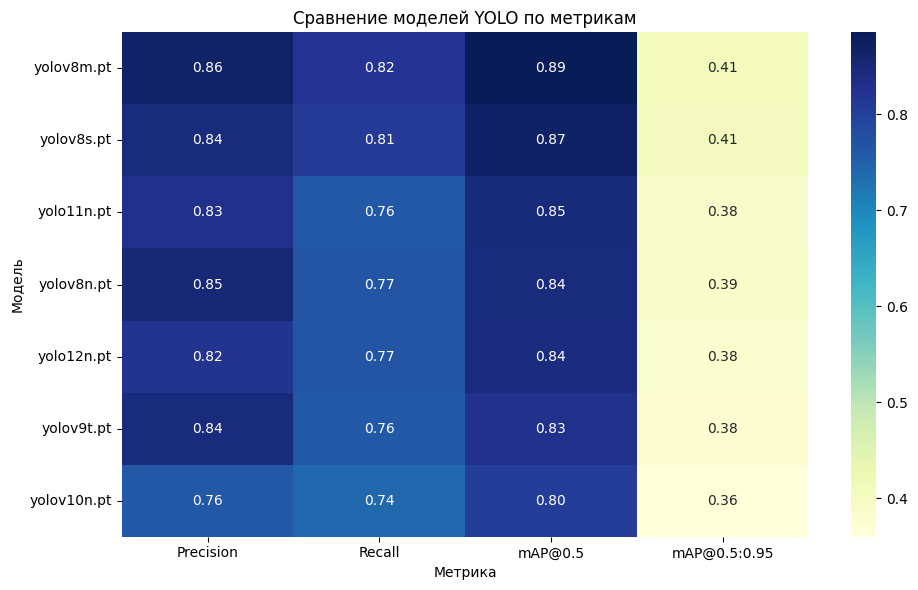

In [13]:
# Сравним метрики на валидационной выборке через тепловую карту

heatmap_data = results_table.drop(columns=["Model"]).set_index(results_table["Model"])

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Сравнение моделей YOLO по метрикам")
plt.ylabel("Модель")
plt.xlabel("Метрика")
plt.tight_layout()
plt.show()

Видим, что модели YOLO-8m и YOLO-8s показывают лучшие результаты на валидации по всем метрикам

In [15]:
# Определим функцию для предсказаний моделями YOLO

def run_yolo_predictions(model, image_directory, output_directory):
    image_directory = Path(image_directory)
    output_directory = Path(output_directory)

    # Пробуем обнаружить чаек на тестовой выборке с помощью модели YOLO

    model.predict(
        source=str(image_directory),
        save_txt=True,
        project=str(output_directory.parent),
        name=output_directory.name
    )

    # Перенесём в файлы в нужную нам папку

    final_directory = output_directory / "labels"

    if final_directory.exists():
        for file in final_directory.glob("*.txt"):
            shutil.move(str(file), str(output_directory / file.name))

        final_directory.rmdir()

    # Добавим пустые текстовые файлы

    for image_path in image_directory.glob("*.jpg"):
        label_path = output_directory / (image_path.stem + ".txt")

        if not label_path.exists():
            label_path.write_text("")

    print(f"YOLO-предсказания сохранены в: {output_directory}")

In [3]:
# Загрузим веса обученных моделей

model_8 = YOLO('runs/detect/train/weights/best.pt')
model_8_1 = YOLO('runs/detect/train2/weights/best.pt')
model_8_2 = YOLO('runs/detect/train3/weights/best.pt')
model_9 = YOLO('runs/detect/train4/weights/best.pt')
model_10 = YOLO('runs/detect/train5/weights/best.pt')
model_11 = YOLO('runs/detect/train6/weights/best.pt')
model_12 = YOLO('runs/detect/train7/weights/best.pt')

In [4]:
# Определим функцию для вычисления IoU

def iou(box_1, box_2):
    def to_usual_format(box):  # функция для перевода в формат (левый верхний угол; правый нижний угол)
        x, y, w, h = box
        return (x - w / 2, y - h / 2), (x + w / 2, y + h / 2)

    box_1 = to_usual_format(box_1)
    box_2 = to_usual_format(box_2)

    inter_x_1 = max(box_1[0][0], box_2[0][0])
    inter_y_1 = max(box_1[0][1], box_2[0][1])
    inter_x_2 = min(box_1[1][0], box_2[1][0])
    inter_y_2 = min(box_1[1][1], box_2[1][1])

    inter_area = max(0, inter_x_2 - inter_x_1) * max(0, inter_y_2 - inter_y_1)  # пересечение прямоугольников
    area_1 = (box_1[1][0] - box_1[0][0]) * (box_1[1][1] - box_1[0][1])
    area_2 = (box_2[1][0] - box_2[0][0]) * (box_2[1][1] - box_2[0][1])
    union_area = area_1 + area_2 - inter_area  # объединение прямоугольников

    return inter_area / (union_area + 1e-6)

In [5]:
# Определим функцию для подсчёта TP, FP, FN

def match_predictions(target_boxes, pred_boxes, iou_threshold=0.5, draw=False):
    matched_targets = set()
    matched_preds = set()

    tp_pairs = []

    for i, target in enumerate(target_boxes):
        for j, pred in enumerate(pred_boxes):
            iou_score = iou(target[1:], pred[1:])

            if iou_score >= iou_threshold and j not in matched_preds:
                matched_targets.add(i)
            
                matched_preds.add(j)
                tp_pairs.append((i, j))
                break

    if draw:
        fp_indices = [j for j in range(len(pred_boxes)) if j not in matched_preds]
        fn_indices = [i for i in range(len(target_boxes)) if i not in matched_targets]

        return tp_pairs, fp_indices, fn_indices

    tp = len(matched_targets)
    fn = len(target_boxes) - tp
    fp = len(pred_boxes) - tp

    return tp, fp, fn

In [6]:
# Определим функцию для общего количества TP, FP, FN во всех файлах

def evaluate_yolo_predictions(target_directory, pred_directory, iou_threshold=0.5):
    target_directory = Path(target_directory)
    pred_directory = Path(pred_directory)

    total_tp = total_fp = total_fn = 0

    for target_file in target_directory.glob("*.txt"):
        pred_file = pred_directory / target_file.name

        if not pred_file.exists():
            print(f'Файл {pred_file} не существует')
            continue

        target_boxes = [list(map(float, line.strip().split())) for line in open(target_file)]
        pred_boxes = [list(map(float, line.strip().split())) for line in open(pred_file)]

        tp, fp, fn = match_predictions(target_boxes, pred_boxes, iou_threshold=iou_threshold)

        total_tp += tp
        total_fp += fp
        total_fn += fn

    return total_tp, total_fp, total_fn

In [12]:
# Определим функцию для вывода метрик и TP, FP, FN

def report_yolo_metrics(target_directory, pred_directory, iou_threshold=0.5):
    tp, fp, fn = evaluate_yolo_predictions(target_directory, pred_directory, iou_threshold=iou_threshold)

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)

    return {
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "Precision": precision,
        "Recall": recall
    }

In [8]:
# Определим функцию для создания изображений с обведёнными прямоугольниками

def draw_boxes(image, boxes, color, thickness=2):
    h, w = image.shape[:2]

    for box in boxes:
        class_id, x_c, y_c, bw, bh = box
        x1 = int((x_c - bw / 2) * w)
        y1 = int((y_c - bh / 2) * h)
        x2 = int((x_c + bw / 2) * w)
        y2 = int((y_c + bh / 2) * h)

        cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)

In [15]:
# Определим функцию для работы с изображениями в определённой папке

def visualize_detections(image_directory, target_directory, pred_directory, output_directory, iou_threshold=0.5):
    image_directory = Path(image_directory)
    target_directory = Path(target_directory)
    pred_directory = Path(pred_directory)
    output_directory = Path(output_directory)
    output_directory.mkdir(exist_ok=True, parents=True)
    
    for image_path in image_directory.glob("*.*"):  # перебираем все файлы с любым расширением
        stem = image_path.stem  # имя файла без расширения
        target_file = target_directory / f"{stem}.txt"
        pred_file = pred_directory / f"{stem}.txt"
        output_file = output_directory / f"{stem}.jpg"

        if not target_file.exists():
            print(f"Target файл не найден для {image_path.name}, пропускаем")
            continue
        
        target_boxes = [list(map(float, line.strip().split())) for line in open(target_file)]
        
        if pred_file.exists():
            pred_boxes = [list(map(float, line.strip().split())) for line in open(pred_file)]
            
        else:
            pred_boxes = []
            print(f"Предсказания не найдены для {image_path.name}, рисуем только FN")

    
        image = cv2.imread(str(image_path))

        if image is None:
            print(f"Не удалось загрузить {image_directory}")
            return

        tp_pairs, fp_indices, fn_indices = match_predictions(target_boxes, pred_boxes, iou_threshold, draw=True)

        # Зеленые — TP (используем целевые координаты)
        draw_boxes(image, [target_boxes[i] for i, _ in tp_pairs], (0, 255, 0))

        # Красные — FP (используем предсказания)
        draw_boxes(image, [pred_boxes[j] for j in fp_indices], (0, 0, 255))

        # Синие — FN (используем targets)
        draw_boxes(image, [target_boxes[i] for i in fn_indices], (255, 0, 0))

        cv2.imwrite(str(output_file), image)

    print(f'Изображения сохранены в {output_directory}')

In [10]:
labels_val_directory = 'data/val/labels'
images_val_directory = 'data/val/images'

In [34]:
# Делаем предсказания с помощью модели YOLO-8n на валидационной выборке

run_yolo_predictions(model_8, 'data/val/images', 'data/val/labels_8')

In [13]:
pred_val_8_directory = 'data/val/labels_8'
report_yolo_metrics(labels_val_directory, pred_val_8_directory, iou_threshold=0.5)

{'TP': 814,
 'FP': 282,
 'FN': 170,
 'Precision': 0.7427007292493606,
 'Recall': 0.8272357715170369}

In [31]:
images_val_8_directory = 'data/val/images_8'
visualize_detections(images_val_directory, labels_val_directory, pred_val_8_directory, images_val_8_directory, iou_threshold=0.5)

Изображения сохранены в data\val\images_8


In [39]:
# Делаем предсказания с помощью модели YOLO-8n на тестовой выборке

run_yolo_predictions(model_8, 'data/test/images', 'data/test/labels_8')

In [444]:
submission_8_path = "submissions/submission_8.csv"
labels_to_csv('data/test/labels_8', submission_8_path)

![Результат](results/result_8_0.png)

Результат без разделения выборки на обучающую и валидационную

![Результат](results/result_8.png)

Результат с разделением выборки на обучающую и валидационную

In [22]:
# Делаем предсказания с помощью модели YOLO-8s на валидационной выборке

run_yolo_predictions(model_8_1, 'data/val/images', 'data/val/labels_8_1')

In [18]:
pred_val_8_1_directory = 'data/val/labels_8_1'
report_yolo_metrics(labels_val_directory, pred_val_8_1_directory, iou_threshold=0.5)

{'TP': 852,
 'FP': 276,
 'FN': 132,
 'Precision': 0.755319148266561,
 'Recall': 0.8658536576566528}

In [19]:
images_val_8_1_directory = 'data/val/images_8_1'
visualize_detections(images_val_directory, labels_val_directory, pred_val_8_1_directory, images_val_8_1_directory, iou_threshold=0.5)

Изображения сохранены в data\val\images_8_1


In [38]:
# Делаем предсказания с помощью модели YOLO-8s

run_yolo_predictions(model_8_1, 'data/test/images', 'data/test/labels_8_1')

In [465]:
submission_8_1_path = "submissions/submission_8_1.csv"
labels_to_csv('data/test/labels_8_1', submission_8_1_path)

![Результат](results/result_8_1.png)

In [23]:
# Делаем предсказания с помощью модели YOLO-8m на валидационной выборке

run_yolo_predictions(model_8_2, 'data/val/images', 'data/val/labels_8_2')

In [20]:
pred_val_8_2_directory = 'data/val/labels_8_2'
report_yolo_metrics(labels_val_directory, pred_val_8_2_directory, iou_threshold=0.5)

{'TP': 834,
 'FP': 219,
 'FN': 150,
 'Precision': 0.7920227912706336,
 'Recall': 0.8475609747484136}

In [21]:
images_val_8_2_directory = 'data/val/images_8_2'
visualize_detections(images_val_directory, labels_val_directory, pred_val_8_2_directory, images_val_8_2_directory, iou_threshold=0.5)

Изображения сохранены в data\val\images_8_2


In [37]:
# Делаем предсказания с помощью модели YOLO-8m

run_yolo_predictions(model_8_2, 'data/test/images', 'data/test/labels_8_2')

In [472]:
submission_8_2_path = "submissions/submission_8_2.csv"
labels_to_csv('data/test/labels_8_2', submission_8_2_path)

![Результат](results/result_8_2.png)

In [24]:
# Делаем предсказания с помощью модели YOLO-9t на валидационной выборке

run_yolo_predictions(model_9, 'data/val/images', 'data/val/labels_9')

In [22]:
pred_val_9_directory = 'data/val/labels_9'
report_yolo_metrics(labels_val_directory, pred_val_9_directory, iou_threshold=0.5)

{'TP': 801,
 'FP': 264,
 'FN': 183,
 'Precision': 0.7521126753501288,
 'Recall': 0.8140243894166419}

In [23]:
images_val_9_directory = 'data/val/images_9'
visualize_detections(images_val_directory, labels_val_directory, pred_val_9_directory, images_val_9_directory, iou_threshold=0.5)

Изображения сохранены в data\val\images_9


In [189]:
# Делаем предсказания с помощью модели YOLO-9t

run_yolo_predictions(model_9, 'data/test/images', 'data/test/labels_9')

YOLO-предсказания сохранены в: data\test\labels_9


In [191]:
submission_9_path = "submissions/submission_9.csv"
labels_to_csv('data/test/labels_9', submission_9_path)

![Результат](results/result_9.png)

In [25]:
# Делаем предсказания с помощью модели YOLO-10n на валидационной выборке

run_yolo_predictions(model_10, 'data/val/images', 'data/val/labels_10')

In [24]:
pred_val_10_directory = 'data/val/labels_10'
report_yolo_metrics(labels_val_directory, pred_val_10_directory, iou_threshold=0.5)

{'TP': 766,
 'FP': 277,
 'FN': 218,
 'Precision': 0.7344199417694919,
 'Recall': 0.7784552837617325}

In [25]:
images_val_10_directory = 'data/val/images_10'
visualize_detections(images_val_directory, labels_val_directory, pred_val_10_directory, images_val_10_directory, iou_threshold=0.5)

Изображения сохранены в data\val\images_10


In [194]:
# Делаем предсказания с помощью модели YOLO-10n

run_yolo_predictions(model_10, 'data/test/images', 'data/test/labels_10')

YOLO-предсказания сохранены в: data\test\labels_10


In [195]:
submission_10_path = "submissions/submission_10.csv"
labels_to_csv('data/test/labels_10', submission_10_path)

![Результат](results/result_10.png)

In [26]:
# Делаем предсказания с помощью модели YOLO-11n на валидационной выборке

run_yolo_predictions(model_11, 'data/val/images', 'data/val/labels_11')

In [26]:
pred_val_11_directory = 'data/val/labels_11'
report_yolo_metrics(labels_val_directory, pred_val_11_directory, iou_threshold=0.5)

{'TP': 783,
 'FP': 259,
 'FN': 201,
 'Precision': 0.7514395386262576,
 'Recall': 0.7957317065084027}

In [27]:
images_val_11_directory = 'data/val/images_11'
visualize_detections(images_val_directory, labels_val_directory, pred_val_11_directory, images_val_11_directory, iou_threshold=0.5)

Изображения сохранены в data\val\images_11


In [199]:
# Делаем предсказания с помощью модели YOLO-11n

run_yolo_predictions(model_11, 'data/test/images', 'data/test/labels_11')

YOLO-предсказания сохранены в: data\test\labels_11


In [200]:
submission_11_path = "submissions/submission_11.csv"
labels_to_csv('data/test/labels_11', submission_11_path)

![Результат](results/result_11.png)

In [27]:
# Делаем предсказания с помощью модели YOLO-12n на валидационной выборке

run_yolo_predictions(model_12, 'data/val/images', 'data/val/labels_12')

In [28]:
pred_val_12_directory = 'data/val/labels_12'
report_yolo_metrics(labels_val_directory, pred_val_12_directory, iou_threshold=0.5)

{'TP': 805,
 'FP': 268,
 'FN': 179,
 'Precision': 0.7502329909131099,
 'Recall': 0.8180894300629172}

In [30]:
images_val_12_directory = 'data/val/images_12'
visualize_detections(images_val_directory, labels_val_directory, pred_val_12_directory, images_val_12_directory, iou_threshold=0.5)

Изображения сохранены в data\val\images_12


In [14]:
# Делаем предсказания с помощью модели YOLO-12n

run_yolo_predictions(model_12, 'data/test/images', 'data/test/labels_12')

In [17]:
submission_12_path = "submissions/submission_12.csv"
labels_to_csv('data/test/labels_12', submission_12_path)

![Результат](results/result_12.png)

С разделением выборки на обучающую и валидационную

![Результат](results/result_12_0.png)

Без разделения выборки на обучающую и валидационную


#### Вывод: YOLO лучше базовых моделей
    Простая CNN и ResNet показали плохие результаты — они не умеют хорошо находить объекты на изображениях
    YOLO изначально создан для задач object detection, поэтому даже лёгкие версии (YOLOv8n, YOLOv12n) работают гораздо лучше
    Если использовать не только обучающую выборку, но и валидацию, результаты ещё лучше — модель меньше переобучается и лучше работает на новых данных
    YOLO проще в использовании, обучается быстрее и даёт стабильные предсказания

*Вывод простой: для задачи поиска чаек YOLO — лучший выбор, особенно если использовать более тяжёлые версии*